In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

import hdbscan
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

In [2]:
# Load data
df = pd.read_csv("C:/Users/HELIOS-300/Desktop/MATLAB/NasaDataCapstone/data/features.csv")

# Separate metadata and features
file_names = df["file_name"]
X = df.drop(columns=["file_name"])

In [3]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: remove near-constant features
X_scaled = VarianceThreshold(threshold=1e-3).fit_transform(X_scaled)

# Fit PCA
pca = PCA(
    n_components=2,
    random_state=42
)

X_pca = pca.fit_transform(X_scaled)

# Explained variance (sanity check)
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())


Explained variance ratio: [0.29049485 0.21590365]
Total explained variance: 0.5063985026688523


In [4]:
# Fit HDBSCAN
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20,
    min_samples=5,
    metric="euclidean"
)

labels = clusterer.fit_predict(X_pca)

# Attach cluster labels
df["cluster"] = labels


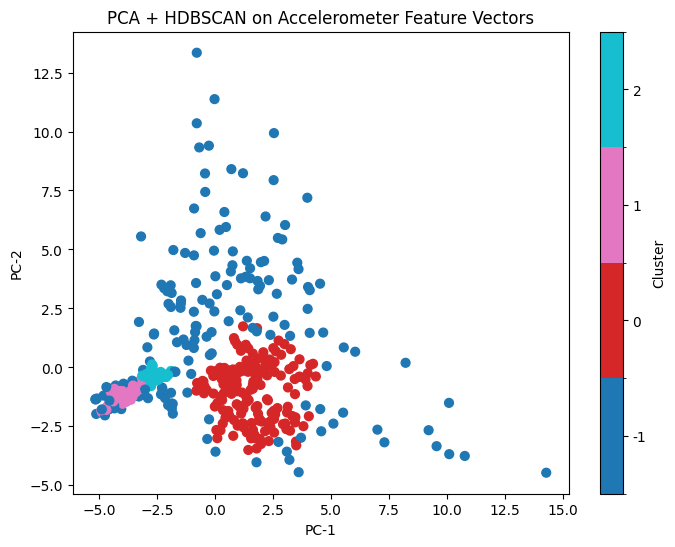

In [5]:
# Visualization
plt.figure(figsize=(8, 6))
unique_labels = np.unique(labels)
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
label_indices = np.array([label_to_index[l] for l in labels])

cmap = plt.get_cmap("tab10", len(unique_labels))
bounds = np.arange(len(unique_labels) + 1) - 0.5
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=label_indices,
    cmap=cmap,
    norm=norm,
    s=40
)
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_ticklabels(unique_labels)
cbar.set_label("Cluster")
plt.title("PCA + HDBSCAN on Accelerometer Feature Vectors")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.show()
